In [1]:
# importing

import os
import shutil
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

2025-03-04 12:47:34.761916: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 12:47:34.773383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741092454.784515     312 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741092454.787979     312 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 12:47:34.801189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import os
current_directory = os.getcwd()
print(current_directory)
dir_base = os.path.join(current_directory,'Dataset')
print(dir_base)
fire_base = os.path.join(dir_base,'fire_images')
print(fire_base)
non_fire_base = os.path.join(dir_base,'non_fire_images')
print(non_fire_base)
# Define new output base directory
output_base = os.path.join(current_directory, 'Output')
print("Output Directory:", output_base)
print(output_base)

/home/ladans/Computer Vision/Final Project
/home/ladans/Computer Vision/Final Project/Dataset
/home/ladans/Computer Vision/Final Project/Dataset/fire_images
/home/ladans/Computer Vision/Final Project/Dataset/non_fire_images
Output Directory: /home/ladans/Computer Vision/Final Project/Output
/home/ladans/Computer Vision/Final Project/Output


In [3]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

fire_images = [os.path.join(fire_base, img) for img in os.listdir(fire_base)]
nonfire_images = [os.path.join(non_fire_base, img) for img in os.listdir(non_fire_base)]

fire_labels = [1] * len(fire_images)
nonfire_labels = [0] * len(nonfire_images)

all_images = fire_images + nonfire_images
all_labels = fire_labels + nonfire_labels
X_train, X_temp, y_train, y_temp = train_test_split(all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=20)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=20)



# Update output directories dynamically
output_dirs = {
    "train": os.path.join(output_base, "train"),
    "val": os.path.join(output_base, "val"),
    "test": os.path.join(output_base, "test")
}
for split in output_dirs:
    os.makedirs(os.path.join(output_dirs[split], "fire"), exist_ok=True)
    os.makedirs(os.path.join(output_dirs[split], "nonfire"), exist_ok=True)
def copy_images(image_paths, labels, split):
    for img_path, label in zip(image_paths, labels):
        category = "fire" if label == 1 else "nonfire"
        dest_path = os.path.join(output_dirs[split], category, os.path.basename(img_path))
        shutil.copy(img_path, dest_path)
        
copy_images(X_train, y_train, "train")
copy_images(X_val, y_val, "val")
copy_images(X_test, y_test, "test")

print("Dataset successfully split and saved.")


Dataset successfully split and saved.


In [4]:
img_size=(320,320)
bth_size=32

# Augmenting Images for training set

trdatagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.1
)

# Only Rescaling or Normalizing the pixel values for testing Set
tedatagen = ImageDataGenerator(rescale=1.0/255)

In [5]:
# Reading the training data from directory

traingen= trdatagen.flow_from_directory(
    os.path.join(output_base, "train"),
    target_size=img_size,
    batch_size=bth_size,
    color_mode='rgb',  
    class_mode='categorical',
    shuffle=True)

# Reading the testing data from Directory

testgen = tedatagen.flow_from_directory(
    os.path.join(output_base, "test"),
    target_size=img_size,
    batch_size=bth_size,
    color_mode='rgb', 
    class_mode='categorical',
    shuffle=False
)

# Validation data 
valgen = trdatagen.flow_from_directory(
    os.path.join(output_base, "val"),
    target_size=img_size,
    batch_size=bth_size,
    color_mode='rgb',  
    class_mode='categorical',
    shuffle=True,
      
)

Found 699 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


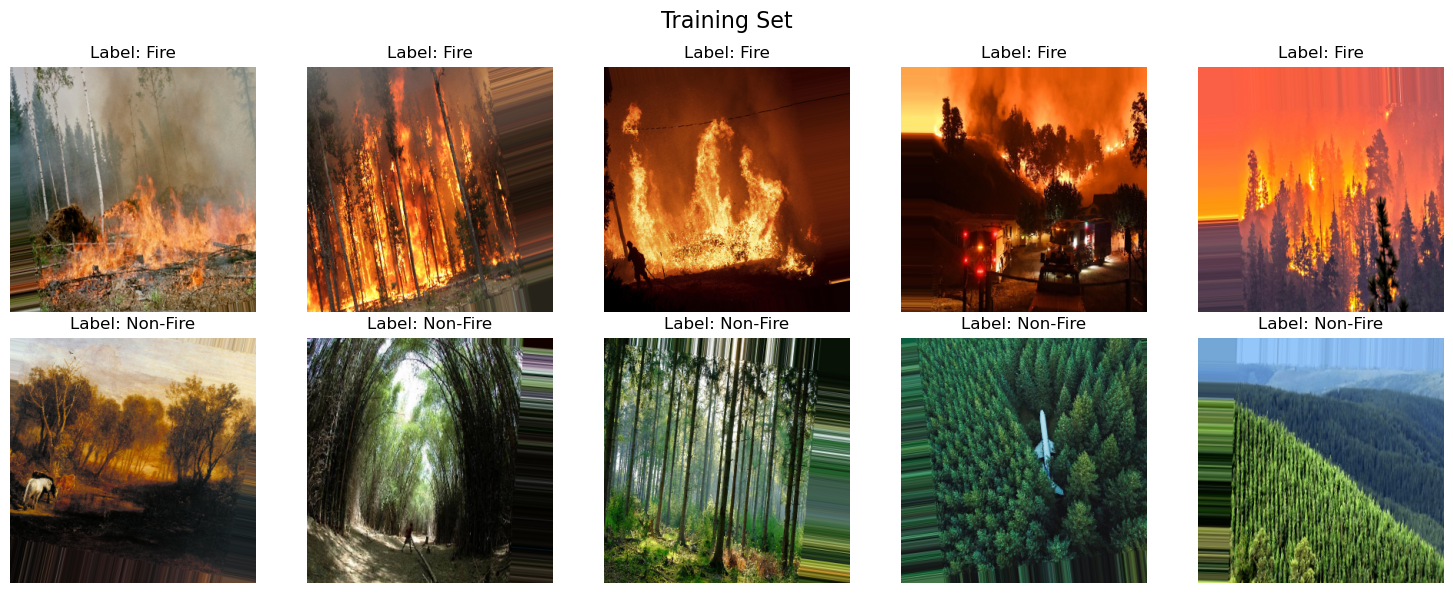

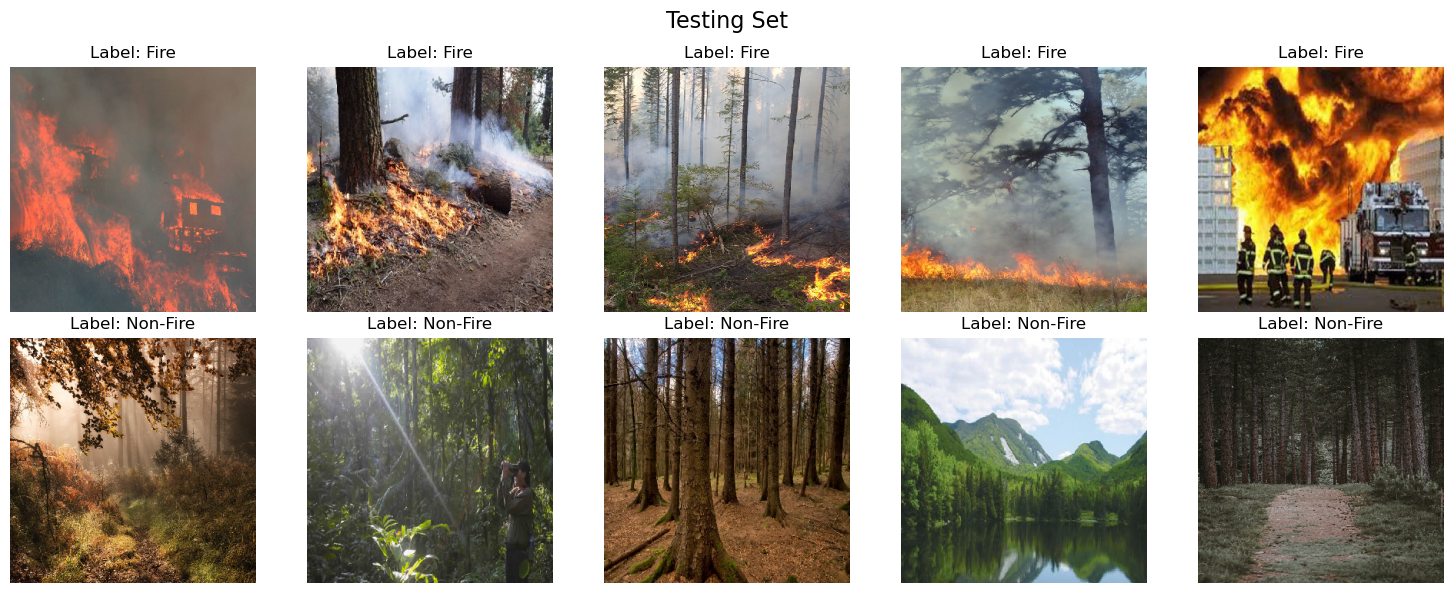

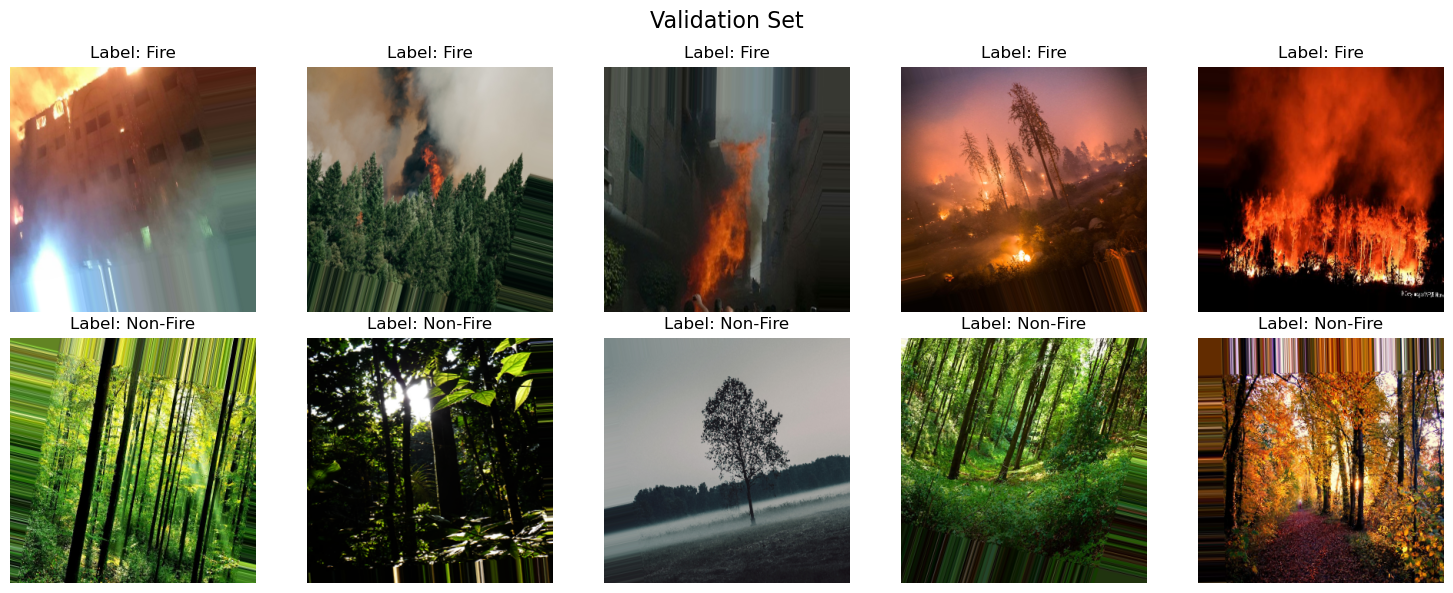

In [6]:
def plot_balanced_images(generator, title, num_per_class=5):
    images_collected = {"fire": [], "nonfire": []}  
    
    while len(images_collected["fire"]) < num_per_class or len(images_collected["nonfire"]) < num_per_class:
        images, labels = next(generator)  
        class_indices = generator.class_indices  
        inv_class_indices = {v: k for k, v in class_indices.items()} 
        class_labels = np.argmax(labels, axis=1)  
        for img, label_idx in zip(images, class_labels):
            class_name = inv_class_indices[label_idx]  
            if class_name in images_collected and len(images_collected[class_name]) < num_per_class:
                images_collected[class_name].append(img)
        if generator.batch_index == 0:
            break  


    selected_images = images_collected["fire"][:num_per_class] + images_collected["nonfire"][:num_per_class]
    labels = ["Fire"] * num_per_class + ["Non-Fire"] * num_per_class
    num_rows = 2 if num_per_class > 1 else 1
    fig, axes = plt.subplots(num_rows, num_per_class, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)
    if num_rows == 1:  
        axes = np.expand_dims(axes, axis=0)

    for i, (img, label) in enumerate(zip(selected_images, labels)):
        ax = axes[i // num_per_class, i % num_per_class]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

plot_balanced_images(traingen, "Training Set")
plot_balanced_images(testgen, "Testing Set")
plot_balanced_images(valgen, "Validation Set")

In [7]:
#####fire
train_fire_dir_ = os.path.join(output_base, "train")
train_fire_dir = os.path.join(train_fire_dir_, "fire")
print(train_fire_dir)
val_fire_dir_ = os.path.join(output_base, "val")
val_fire_dir = os.path.join(val_fire_dir_, "fire")
print(val_fire_dir)
test_fire_dir_ = os.path.join(output_base, "test")
test_fire_dir = os.path.join(test_fire_dir_, "fire")
print(test_fire_dir)
######non_fire
train_nonfire_dir_ = os.path.join(output_base, "train")
train_nonfire_dir = os.path.join(train_nonfire_dir_, "nonfire")
print(train_nonfire_dir)
val_nonfire_dir_ = os.path.join(output_base, "val")
val_nonfire_dir = os.path.join(val_nonfire_dir_, "nonfire")
print(val_nonfire_dir)
test_nonfire_dir_ = os.path.join(output_base, "test")
test_nonfire_dir = os.path.join(test_nonfire_dir_, "nonfire")
print(test_nonfire_dir)

/home/ladans/Computer Vision/Final Project/Output/train/fire
/home/ladans/Computer Vision/Final Project/Output/val/fire
/home/ladans/Computer Vision/Final Project/Output/test/fire
/home/ladans/Computer Vision/Final Project/Output/train/nonfire
/home/ladans/Computer Vision/Final Project/Output/val/nonfire
/home/ladans/Computer Vision/Final Project/Output/test/nonfire


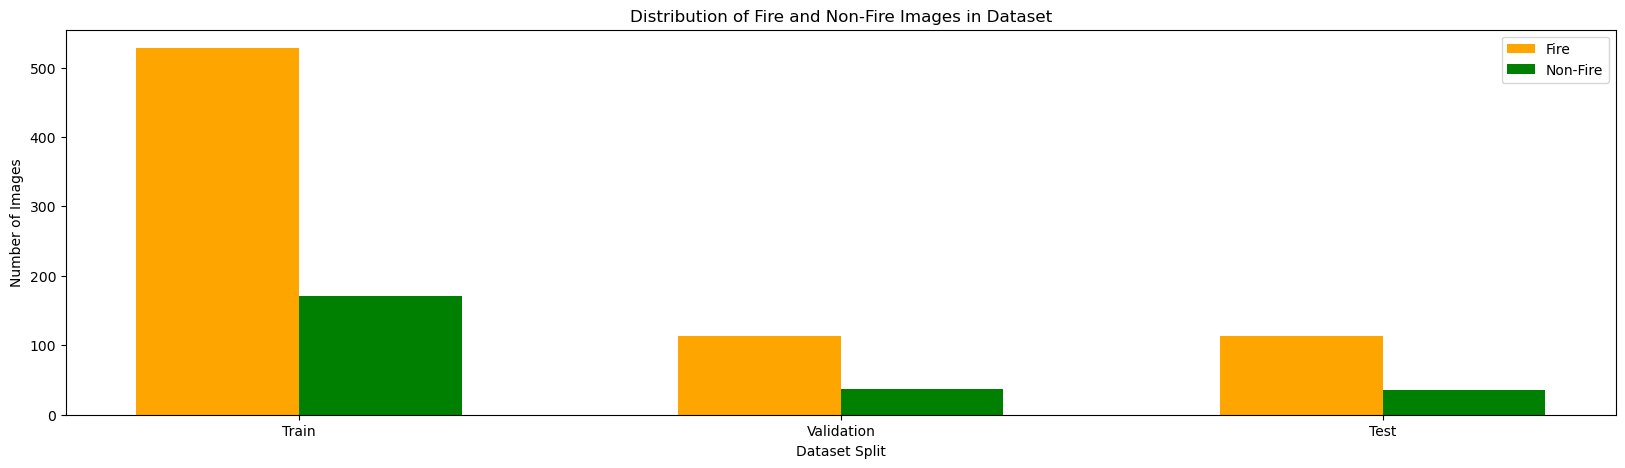

In [8]:
train_fire = len(os.listdir(train_fire_dir))
val_fire = len(os.listdir(val_fire_dir))
test_fire = len(os.listdir(test_fire_dir))
train_nonfire = len(os.listdir(train_nonfire_dir))
val_nonfire = len(os.listdir(val_nonfire_dir))
test_nonfire = len(os.listdir(test_nonfire_dir))

categories = ["Train", "Validation", "Test"]
fire_counts = [train_fire, val_fire, test_fire]
nonfire_counts = [train_nonfire, val_nonfire, test_nonfire]


x = np.arange(len(categories))  
width = 0.3 

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(x - width/2, fire_counts, width, label="Fire", color="orange")  # Fire images
ax.bar(x + width/2, nonfire_counts, width, label="Non-Fire", color="green")  # Non-fire images

ax.set_xlabel("Dataset Split")
ax.set_ylabel("Number of Images")
ax.set_title("Distribution of Fire and Non-Fire Images in Dataset")
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.show()

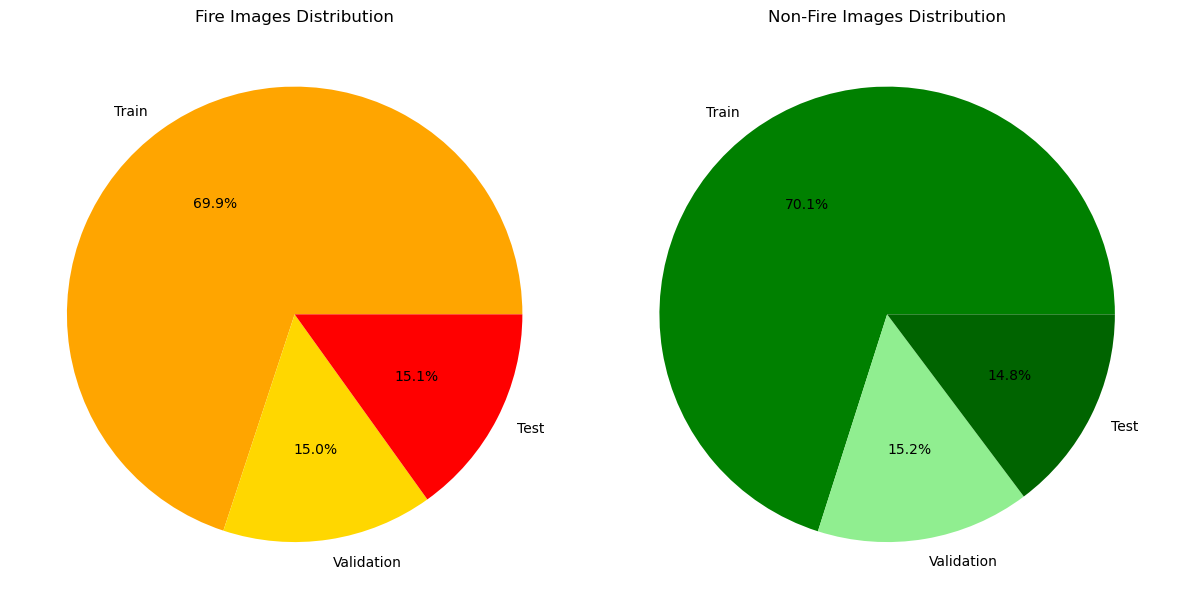

In [9]:
# Labels for dataset splits
labels = ['Train', 'Validation', 'Test']

# Data for fire and non-fire images
fire_counts = [train_fire, val_fire, test_fire]
non_fire_counts = [train_nonfire, val_nonfire, test_nonfire]

# Create figure for two pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Fire Images Pie Chart
axes[0].pie(fire_counts, labels=labels, autopct='%1.1f%%', colors=['orange', 'gold', 'red'])
axes[0].set_title('Fire Images Distribution')

# Non-Fire Images Pie Chart
axes[1].pie(non_fire_counts, labels=labels, autopct='%1.1f%%', colors=['green', 'lightgreen', 'darkgreen'])
axes[1].set_title('Non-Fire Images Distribution')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

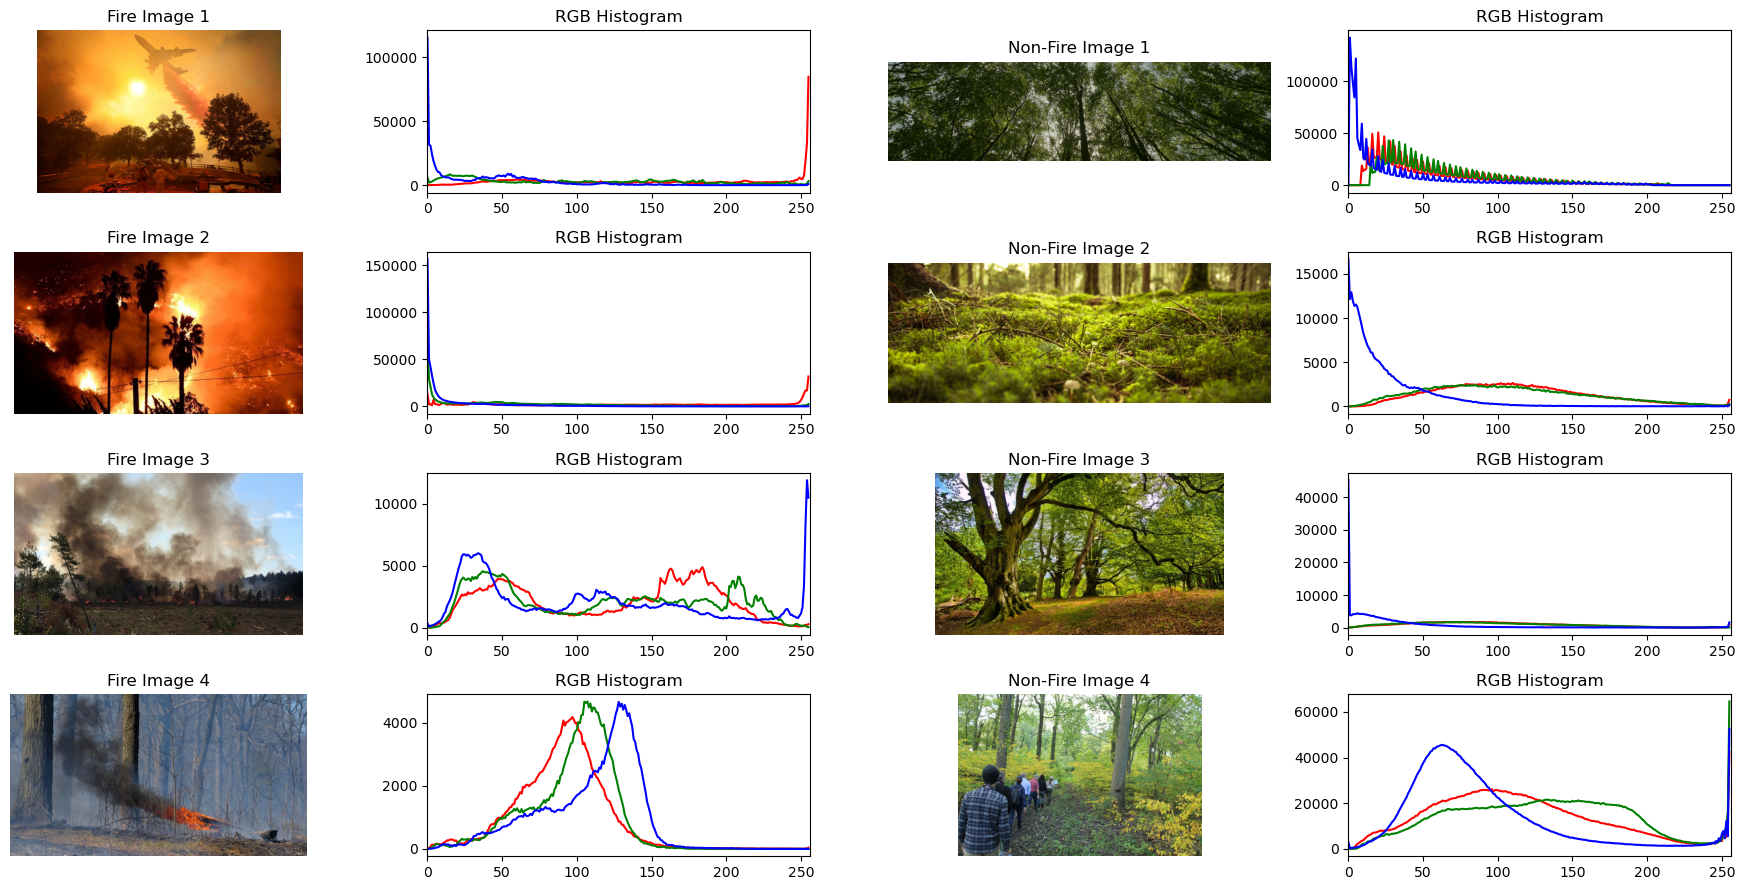

In [10]:
#HISTOGRAM analysis:
# Define fire and non-fire directories
import cv2
fire_dir = train_fire_dir  # Fire images
nonfire_dir = train_nonfire_dir  # Non-fire images

# Function to load three random images from a directory
def load_random_images(image_dir, num_images=4):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    if len(image_files) < num_images:
        return None  # Return None if not enough images found
    selected_images = random.sample(image_files, num_images)
    images = [cv2.cvtColor(cv2.imread(os.path.join(image_dir, img)), cv2.COLOR_BGR2RGB) for img in selected_images]
    return images

# Load three random fire and non-fire images
fire_images = load_random_images(fire_dir, num_images=4)
nonfire_images = load_random_images(nonfire_dir, num_images=4)

# Check if images were loaded
if fire_images is not None and nonfire_images is not None:
    # Create subplots for fire and non-fire images with histograms
    fig, axes = plt.subplots(4, 4, figsize=(18, 9))

    # Function to plot image and its histogram
    def plot_histogram(image, ax_img, ax_hist, title):
        ax_img.imshow(image)
        ax_img.set_title(title)
        ax_img.axis('off')

        colors = ('r', 'g', 'b')
        for i, color in enumerate(colors):
            hist = cv2.calcHist([image], [i], None, [256], [0, 256])
            ax_hist.plot(hist, color=color)
            ax_hist.set_xlim([0, 256])
        ax_hist.set_title("RGB Histogram")

    # Plot Fire Images and Histograms
    for i in range(4):
        plot_histogram(fire_images[i], axes[i, 0], axes[i, 1], f"Fire Image {i+1}")

    # Plot Non-Fire Images and Histograms
    for i in range(4):
        plot_histogram(nonfire_images[i], axes[i, 2], axes[i, 3], f"Non-Fire Image {i+1}")

    # Adjust layout
    plt.tight_layout()
    plt.show()
else:
    print("Could not load enough images from the specified directories.")


In [11]:
import keras as k
from keras.models import Sequential
from keras.layers import Conv2D,BatchNormalization,Activation,GlobalAveragePooling2D,Dropout,Dense,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

In [12]:
# Define model
model = Sequential()

# CNN Layer 1
model.add(Conv2D(32, (3,3), padding='same', input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# CNN Layer 2
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# CNN Layer 3
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Global Average Pooling instead of Flatten
model.add(GlobalAveragePooling2D())

# Dense Layer
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(2, activation='sigmoid'))

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-04 12:47:54.880938: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 320, 320, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320, 320, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 160, 160, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,706 (502.76 KB)

 Trainable params: 127,746 (499.01 KB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
#Implementing Early Stopping and Learning Rate Reduction
es=EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
lr=ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, verbose=1, min_delta=0.0001)

callbacks_list=[es,lr]

In [14]:
history = model.fit(
    traingen,
    epochs=5,
    validation_data=valgen,
    callbacks=callbacks_list
)

/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7529 - loss: 0.5519 - val_accuracy: 0.7533 - val_loss: 0.6004 - learning_rate: 0.0010
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 981ms/step - accuracy: 0.9078 - loss: 0.2907 - val_accuracy: 0.7533 - val_loss: 0.5540 - learning_rate: 0.0010
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 992ms/step - accuracy: 0.9426 - loss: 0.1794 - val_accuracy: 0.7533 - val_loss: 0.5499 - learning_rate: 0.0010
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 981ms/step - accuracy: 0.9362 - loss: 0.1903 - val_accuracy: 0.7533 - val_loss: 0.5615 - learning_rate: 0.0010
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 956ms/step - accuracy: 0.9337 - loss: 0.1636 - val_accuracy: 0.7533 - val_loss: 0.5964 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.


In [15]:
test_loss, test_accuracy = model.evaluate(testgen)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.9018 - loss: 0.3435


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical

Test Accuracy: 0.76
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       114
           1       0.00      0.00      0.00        36

    accuracy                           0.76       150
   macro avg       0.38      0.50      0.43       150
weighted avg       0.58      0.76      0.66       150

Confusion Matrix:
[[114   0]
 [ 36   0]] 




/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


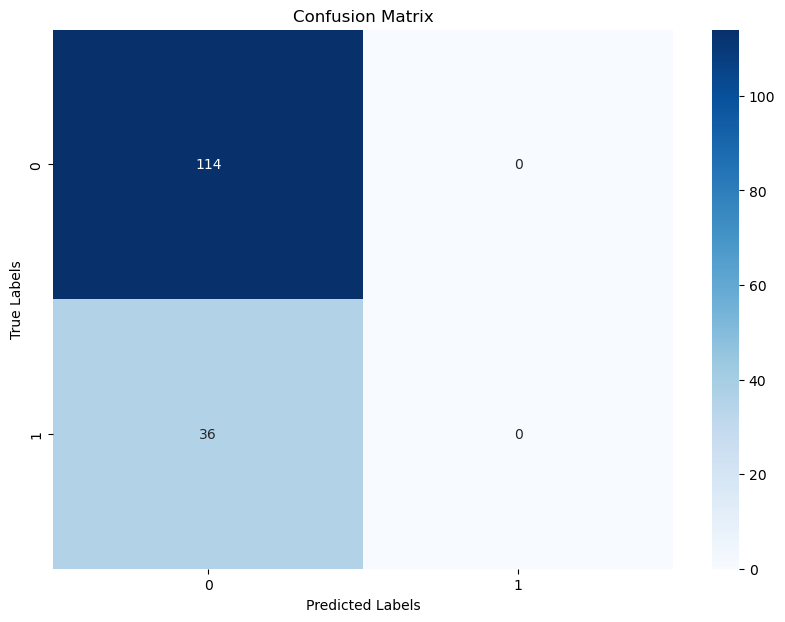

Training class indices: {'fire': 0, 'nonfire': 1}
Test class indices: {'fire': 0, 'nonfire': 1}


In [17]:
print(f"Test Accuracy: {test_accuracy:.2f}")
y_pred = np.argmax(model.predict(testgen), axis=1)
y_true = testgen.classes
print("Classification Report:")
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix,'\n\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', )
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print("Training class indices:", traingen.class_indices)
print("Test class indices:", testgen.class_indices)

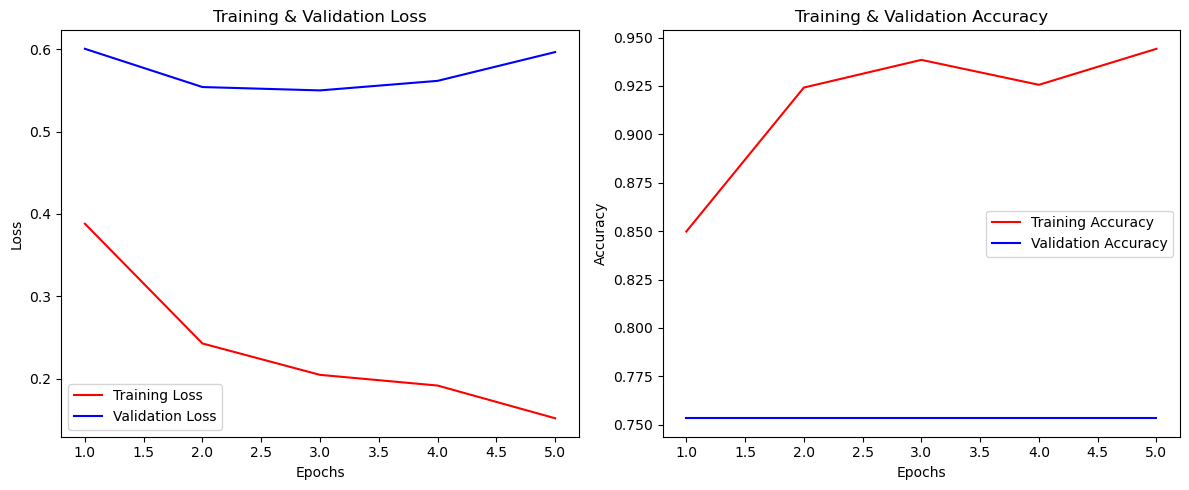

In [18]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()